In [ ]:
import tifffile as tiff
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive/')
from keras.preprocessing.image import ImageDataGenerator

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
from keras.preprocessing.image import ImageDataGenerator

img_height, img_width = 256, 256

train_data_dir = '/content/drive/MyDrive/Colab Notebooks/data from kaggle/train/'
validation_data_dir = '/content/drive/MyDrive/Colab Notebooks/data from kaggle/val/'
test_data_dir = '/content/drive/MyDrive/Colab Notebooks/data from kaggle/test/'

# normalize the pixel values from [0, 255] to [0, 1] interval
datagen = ImageDataGenerator(rescale=1./255)

# automagically retrieve images and their classes for train and validation sets
batch_size = 32 

train_generator = datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        color_mode = 'rgb',
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        color_mode = 'rgb',
        batch_size=batch_size,
        class_mode='categorical')
test_batches = datagen.flow_from_directory(directory=test_data_dir, target_size=(256,256), classes=['Grade0', 'Grade1','Grade2','Grade3','Grade4'], batch_size=10, shuffle=False)

Found 171 images belonging to 5 classes.
Found 55 images belonging to 5 classes.
Found 106 images belonging to 5 classes.


In [ ]:
test_imgs, test_labels = next(test_batches)

In [ ]:
t=test_batches.classes

In [ ]:
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint


img_width, img_height = 256,256
input_dim = 256*256
output_dim = 5

def CNN():
    model = Sequential()
    model.add(Conv2D(32, (3,3), input_shape = (img_width, img_height, 3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3,3), activation = 'relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(500, activation = 'relu'))
    model.add(Dense(500, activation = 'relu'))
    model.add(Dense(500, activation = 'relu'))
    model.add(Dense(500, activation = 'relu'))
    model.add(Dense(5, activation = 'softmax')) 
    return model

model = CNN()

In [ ]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) # compile model

In [ ]:
import os

# print model information
model.summary()
nb_epoch = 10
outputFolder = 'weights/'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)

filepath=outputFolder+"/weights-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, \
                             save_best_only=False, save_weights_only=True, \
                             mode='auto', period=1,save_freq= "epoch")
callbacks_list = [checkpoint]




model_info = model.fit(
        train_generator,
        epochs=nb_epoch,
        batch_size=100,
        validation_data=validation_generator,
        validation_batch_size=100,
        callbacks=callbacks_list)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 64)      

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


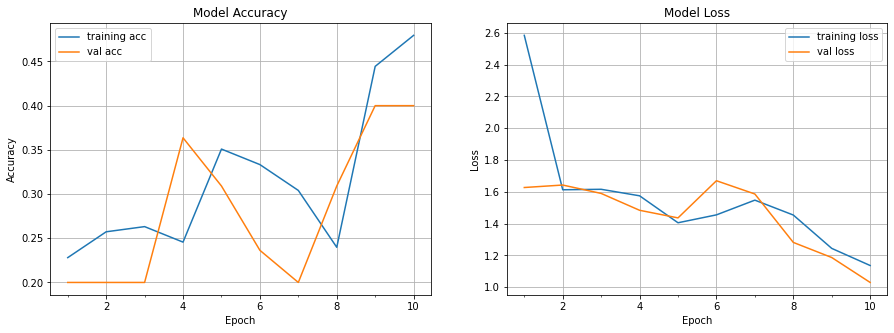

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # model history for accuracy
    axs[0].plot(range(1,len(model_history.history['accuracy'])+1),model_history.history['accuracy'])
    axs[0].plot(range(1,len(model_history.history['val_accuracy'])+1),model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['accuracy'])+1),len(model_history.history['accuracy'])/10)
    axs[0].legend(['training acc', 'val acc'], loc='best')
    axs[0].grid(True)
    # model history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['training loss', 'val loss'], loc='best')
    axs[1].grid(True)
    plt.show()
plot_model_history(model_info)

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
_, training_accuracy = model.evaluate_generator(train_generator, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
print('training accuracy: %.2f' % (training_accuracy*100))

_, validation_accuracy = model.evaluate(validation_generator, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)
print('validation accuracy: %.2f' % (validation_accuracy*100))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


training accuracy: 47.37
validation accuracy: 40.00


In [ ]:
test_generator = datagen.flow_from_directory(
        test_data_dir,
        target_size=(img_width, img_height),
        color_mode = 'rgb',
        batch_size=batch_size,
        class_mode='categorical')
# test_batches = datagen.flow_from_directory(directory=test_data_dir, target_size=(256,256), classes=['Grade0', 'Grade1','Grade2','Grade3','Grade4'], batch_size=10, shuffle=False)

Found 106 images belonging to 5 classes.


In [ ]:

_, test_accuracy = model.evaluate_generator(test_generator, steps=None, callbacks=None, max_queue_size=10, workers=1, use_multiprocessing=False, verbose=0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  


In [ ]:
print('test accuracy: %.2f' % (test_accuracy*100))

test accuracy: 31.13
